In [121]:
import time
import string
import re


punctu = ['.', ',', '!', '?', ';', ':', '—',
          '(', ')', '[', ']', '{', '}', '/', '\\', '|', '-', '_', '=', '+', '*', '&', '^', '%', '$', '#', '@', '~', '`', '\'', '\"']


def wordTokenizer(str):
    wrds= []
    for w in str.split():
        wrds.append(w)
    return wrds


def remove_punctuations(text):
    for p in punctu:
        text = text.replace(p, '')
    return text


def removeURL(text):
    return re.sub(r'https?://\S+|www\.\S+', "<URL>", text)


def removeHashtag(text):
    return re.sub(r'#[a-xA-Z]+', '<HASHTAG>', text)


def removeMentions(text):
    return re.sub(r'@\S+', '<MENTION>', text)


def removeEmail(text):
    return re.sub(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', '<EMAIL>', text)


def removeNumber(text):
    return re.sub(r'[0-9]+(,([0-9]+))*(\.([0-9]+))?%?\s', '<NUMBER> ', text)

def removeExtraSpace(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'^\s+', '', text)
    text = re.sub(r'\s+$', '', text)
    return text

def removeExtraLine(text):
    text = re.sub(r'\n+', '', text)
    return text

def removeDataTime(text):
    text = re.sub(
        r'\d{2,4}\-\d\d-\d{2,4}|\d{2,4}\/\d\d\/\d{2,4}|\d{2,4}:\d\d:?\d{2,4}', '<DATE>', text)
    return re.sub(r'\d+:\d\d:?\d{0,2}?( am|am| pm|pm)', r'<TIME>', text)

def replaceApostrophe( txt_line):
    # Replacing n't with not
    t1 = re.sub(r'can\'t', r'can not', txt_line)
    t1 = re.sub(r'won\'t', r'will not', txt_line)
    t1 = re.sub(r'([a-zA-Z]+)n\'t', r'\1 not', txt_line)
    # Replacing That's, he's, she's etc. with <root> is.
    t1 = re.sub(r'([a-zA-Z]+)\'s', r'\1 is', t1)
    # Replacing i'm.
    t1 = re.sub(r'([iI])\'m', r'\1 am', t1)
    # Replacing we've, i've.
    t1 = re.sub(r'([a-zA-Z]+)\'ve', r'\1 have', t1)
    # Replacing i'd, they'd.
    t1 = re.sub(r'([a-zA-Z]+)\'d', r'\1 had', t1)
    # Replacing i'll, they'll.
    t1 = re.sub(r'([a-zA-Z]+)\'ll', r'\1 will', t1)
    # Replacing we're, they're.
    t1 = re.sub(r'([a-zA-Z]+)\'re', r'\1 are', t1)
    # Replacing tryin', doin'.
    t1 = re.sub(r'([a-zA-Z]+)in\'', r'\1ing', t1)
    return t1


def Clean(str):
    str = str.lower()
    str = removeURL(str)
    str = removeHashtag(str)
    str = removeMentions(str)
    str = removeEmail(str)
    str = remove_punctuations(str)
    str = removeDataTime(str)
    str = removeNumber(str)
    str = replaceApostrophe(str)
    str = removeExtraSpace(str)
    return str

def Token(str):
    x = Clean(str)
    return wordTokenizer(x)




In [119]:
# str = "—it sshsh —shih fhi hfhsi ihs fhsf if—"
# print(Clean(str))


In [104]:
given_corpus = open('../DATA/Pride and Prejudice - Jane Austen.txt', 'r')
new_coropus = open('../DATA/cleaned_corpus.txt', 'w')
for tweet in given_corpus:
    if(tweet == '\n'):
        continue
    new_coropus.write(Clean(tweet)+'\n')

new_coropus.close()
given_corpus.close()


In [105]:
from collections import defaultdict
def paddedString(str,n):
    """
    pad the string with <s> and </s> for n gram
    """
    str = (['<s>']*(n-1)) + str + (['</s>']*(n-1))
    return str

def createFreqTable(trainFile,n):
    """
    create a freq dictionary for each n gram 
    and create a vocab set for each n gram
    """
    # open the file and read the data
    with open(trainFile, 'r') as f:
        data = f.readlines()
    data = [line.strip() for line in data]
    uniWordsFreq = {}
    allWordsSentences = []
    for sentence in data:
        # print(sentence)
        words = Token(sentence)
        words = list(words)
        allWordsSentences.append(words)
        for word in words :
            if uniWordsFreq.get(word) is None:
                uniWordsFreq[word] = 1
            else:
                uniWordsFreq[word] += 1

    uniWordsVocab = set(uniWordsFreq.keys())
    uniWordsVocab = uniWordsVocab.difference(word for word in uniWordsVocab if uniWordsFreq[word] <= 10)
    uniWordsVocab.update({'<UNK>', '<s>', '</s>'})
     
    regenratedData = []
    for sentence in allWordsSentences:
        newSentence = []
        newSentence += [word if word in uniWordsVocab else '<UNK>' for word in sentence]
        regenratedData += [paddedString(newSentence,n)]

    ngramFreq = [defaultdict(lambda: 0) for i in range(n)]
    for sent in regenratedData:
        for ind in range(n-1,len(sent)):
            ngram = (sent[ind],)
            for i in range(1,n+1):
                ngramFreq[i-1][ngram]+=1
                ngram = (sent[ind-i],) + ngram

    return ngramFreq, uniWordsVocab 


In [106]:

def calforallContext(ngramFreq,n):
    """
    calculate the count of occurence of every context  and the sum of freq
    """
    contextTable = [defaultdict(lambda: 0) for i in range(n)]
    contextCntTable = [defaultdict(lambda: 0) for i in range(n)]
    contextWordTable = [defaultdict(lambda: 0) for i in range(n)]
    totWordGram = [0 for i in range(n)]
    for i in range(1,n+1):
        ngramItems = ngramFreq[i-1].items()
        for cnt,freq in ngramItems :
            if freq>0:
                contextTable[i-1][cnt[:-1]] += freq
                contextCntTable[i-1][cnt[:-1]]+=1
                contextWordTable[i-1][cnt[-1]]+=1
                totWordGram[i-1]+=1
    return contextTable,contextCntTable,contextWordTable,totWordGram


In [107]:
import random 

def splitTestTrainData(dataFile, trainFile, testFile):
    """
    Split the data into train and test data.

    Parameters:
    - dataFile: The data file.
    - trainFile: The train file.
    - testFile: The test file.
    """
    with open(dataFile, 'r') as f:
        data = f.readlines()
    
    # first 1000 lines in test data other in train data
    random.shuffle(data)
    with open(trainFile, 'w') as f:
        f.writelines(data[1000:])
    with open(testFile, 'w') as f:
        f.writelines(data[:1000])

splitTestTrainData('../DATA/cleaned_corpus.txt','../DATA/train1.txt','../DATA/test1.txt')
splitTestTrainData('../DATA/cleaned_corpus2.txt','../DATA/train2.txt','../DATA/test2.txt')


In [47]:
!pip3 install dill

In [108]:
# save both corpus ngram frequencies and context table in a file using pickle
import pickle
import dill

def saveModel(modelFile,ngramFreq,contextTable,contextCntTable,uniWordsVocab,contextWordTable,totWordGram):
    with open(modelFile,'wb') as f:
        dill.dump((ngramFreq,contextTable,contextCntTable,uniWordsVocab,contextWordTable,totWordGram),f, protocol=pickle.HIGHEST_PROTOCOL)

# load the model from the file
def loadModel(modelFile):
    with open(modelFile,'rb') as f:
        return dill.load(f)
    
# sstore for firsst corpus
ngramFreq, uniWordsVocab = createFreqTable('../DATA/train1.txt',4)
contextTable,contextCntTable,contextWordTable,totWordGram = calforallContext(ngramFreq,4)
saveModel('../DATA/model1.pkl',ngramFreq,contextTable,contextCntTable,uniWordsVocab,contextWordTable,totWordGram)

# store for second corpus
ngramFreq, uniWordsVocab = createFreqTable('../DATA/train2.txt',4)
contextTable,contextCntTable,contextWordTable,totWordGram = calforallContext(ngramFreq,4)
saveModel('../DATA/model2.pkl',ngramFreq,contextTable,contextCntTable,uniWordsVocab,contextWordTable,totWordGram)


In [109]:
from collections import defaultdict
import math

class KneserNey:
    def __init__(self,vocab, ngramFreq, n, d,contextTable,contextCntTable,contextWordTable,totWordGram):
        """
        Initialize the Kneser-Ney language model.

        Parameters:
        - vocab: A set of words in the vocabulary.
        - ngram_frequencies: A list of dictionaries containing the frequencies of each n-gram for n from 1 to n.
        - n: The order of the model (n-gram).
        - d: The discounting factor (default is 0.75).
        """
        self.vocab = vocab
        self.ngram_frequencies = ngramFreq
        ngramItems = [freq.items() for freq in ngramFreq]
        self.ngram_items = ngramItems
        self.n = n
        self.d = d
        self.dpProb = {}
        self.contextTable, self.contextCntTable = contextTable,contextCntTable
        self.contextWordTable = contextWordTable
        self.totWordGram = totWordGram
    
    def absDiscounting(self,count,countTotal):
        """
        Absolute discounting formula
        """
        return max(0,count-self.d)/countTotal
    
    def lambdaCount(self,countTotal,num):
        """
        lambda count formula
        """
        return (self.d/countTotal)*num
    
    def calProbContext(self,ind,currWord,context):
        cnt=0
        cntMatch = 0
        # sum = self.ngram_frequencies[ind-1][(currWord,)]
        for befContext, freq in self.ngram_items[ind]:
            if freq > 0 :
                cnt+=1
                if befContext[1] == currWord:
                    cntMatch+=1

        return cntMatch,cnt
    
    def getProbability(self, ind, sentence):
        """
        Get the probability of a indth word using (ind -n +1) to ind as context 
        Parameters:
        - ind: The index of the word.
        - sentence: The sentence.
        - dpProb: A dictionary containing the probabilities of each n-gram for n from 1 to n.
        """
        currWord = sentence[ind]
        context = sentence[ind-self.n+1:ind]
        currWord = currWord if currWord in self.vocab else '<UNK>'
        context = [word if word in self.vocab else '<UNK>' for word in context]
        try:
            prob = self.dpProb[tuple(context + [currWord])]
        except KeyError:
            denominator = self.totWordGram[1]
            numerator = self.contextWordTable[1][currWord]
            if numerator == 0:
                prob = self.d/self.ngram_frequencies[0][('<UNK>',)]
            else:
                prob = numerator/denominator
            for i in range(2, self.n+1):
                oldContext = context[-i+1:]
                oldWord = tuple(oldContext+[currWord])
                freqofOldWord = self.ngram_frequencies[i-1][oldWord]
                deno = self.contextTable[i-1][tuple(oldContext,)]
                num = self.contextCntTable[i-1][tuple(oldContext,)]
                if deno ==0:
                    prob = self.d/self.ngram_frequencies[0][('<UNK>',)]
                else:
                    prob = self.absDiscounting(freqofOldWord, deno) + self.lambdaCount(deno,num)*prob
            prob = math.log(prob)
            self.dpProb[tuple(context+[currWord])] = prob
        return prob

    def perplexity(self, sentence, isTokenized):
        if(isTokenized == 'not'):
            sentence = paddedString(Token(sentence), self.n)
        else:
            sentence = paddedString(sentence, self.n)
        logp = 0
        for index in range(self.n-1, len(sentence)):
            lp = self.getProbability(index, sentence)
            logp += lp
        perpl = math.exp(logp*(-1/len(sentence)))
        return perpl




In [110]:
# witten bell smoothing
class WittenBell:
    def __init__(self,vocab, ngramFreq, n,contextTable,contextCntTable,contextWordTable,totWordGram):
        """
        Initialize the Witten-Bell language model.

        Parameters:
        - vocab: A set of words in the vocabulary.
        - ngram_frequencies: A list of dictionaries containing the frequencies of each n-gram for n from 1 to n.
        - n: The order of the model (n-gram).
        """
        self.vocab = vocab
        self.ngram_frequencies = ngramFreq
        self.ngram_items = [freq.items() for freq in ngramFreq]
        self.n = n
        self.dpProb = {}
        self.contextTable, self.contextCntTable = contextTable,contextCntTable
        self.contextWordTable = contextWordTable
        self.totWordGram = totWordGram

    def lambdaCount(self, cntpos,sumtot):
        """
        lambda count formula
        """
        return (cntpos/(sumtot+cntpos))
    

    def getProbability(self,ind,sentence):
        """
        Get the probability of a indth word using (ind -n +1) to ind as context
        Parameters:
        - ind: The index of the word.
        - sentence: The sentence.
        - dpProb: A dictionary containing the probabilities of each n-gram for n from 1 to n.

        Returns:
        - The probability of the word.
        """
        currWord = sentence[ind]
        context = sentence[ind-self.n+1:ind]
        currWord = currWord if currWord in self.vocab else '<UNK>'
        context = [word if word in self.vocab else '<UNK>' for word in context]
      
        try:
            prob = self.dpProb[tuple(context + [currWord])]
        except KeyError:
            pair = tuple(context[-1] + currWord)
            freqofPair = self.ngram_frequencies[1][pair] 
            if(freqofPair == 0):
                prob = 1/self.ngram_frequencies[0][('<UNK>',)]
            else: 
                prob = freqofPair/self.ngram_frequencies[0][(context[-1],)]

            for i in range(2,self.n + 1):
                oldContext = context[-i+1:]
                oldWord = tuple(oldContext+[currWord])
                freqofOldWord = self.ngram_frequencies[i-1][oldWord]
                cw = self.contextCntTable[i-1][tuple(oldContext,)]
                sm = self.contextTable[i-1][tuple(oldContext,)]
                try :
                    lamb = self.lambdaCount(cw,sm)
                except ZeroDivisionError:
                    prob = 1/self.ngram_frequencies[0][('<UNK>',)]
                    break
                pML = freqofOldWord/sm
                prob = (1-lamb)*pML + lamb*prob

            prob = math.log(prob)
        
            self.dpProb[tuple(context+[currWord])] = prob
        return prob
    
    def perplexity(self, sentence,isTokenized):
        if(isTokenized == 'not'):
            prevLength = len(sentence)
            sentence = paddedString(Token(sentence), self.n)
        else:
            prevLength = len(sentence)
            sentence = paddedString(sentence, self.n)
        logp = 0
        # print(len(sentence))
        for index in range(self.n-1, len(sentence)):
            lp = self.getProbability(index, sentence)
            logp += lp

        try:
            perpl = math.exp(logp*(-1/len(sentence)))
        except:
            perpl = float("inf")
        return perpl
        


In [111]:

def generateResult(model, testFile, resultFile):
    """
    Generate the result file.

    Parameters:
    - model: The language model.
    - testFile: The test file.
    - resultFile: The result file.
    """

    dataFile = open(testFile, 'r')
    resFile = open(resultFile, 'w')
    storeResults = []
    avgPerplexity = 0
    totLines = 0
    start = time.time()
    for sentence in dataFile:
        sentence = sentence.rstrip()
        tokens = Token(sentence)
        perplexity = model.perplexity(tokens, 'tok')
        if(perplexity != 'nan'):
            avgPerplexity += perplexity
        totLines += 1
        storeResults.append((sentence, perplexity))
    
    avgPerplexity = avgPerplexity/totLines
    resFile.write(f"Average Perplexity: {avgPerplexity}\n") 
    for sentence, perplexity in storeResults:
        resFile.write(f"{sentence}\t {perplexity}\n")
    resFile.close()
    dataFile.close()
       

In [112]:
import os
import sys
import math
import time 

def language_model(n,smoothingMethod, corupsPath, trainResult, testResult):
    # if files doesn't exist, create them
    if not os.path.exists(trainResult):
        open(trainResult, 'w').close()
    if not os.path.exists(testResult):
        open(testResult, 'w').close()
    start = time.time()
    if corupsPath == '../DATA/cleaned_corpus.txt':
        ngramFreq,contextTable,contextCntTable,vocab,contextWordTable,totWordGram = loadModel('../DATA/model1.pkl')
        trainFileName = '../DATA/train1.txt'
        testFileName = '../DATA/test1.txt'
    if corupsPath == '../DATA/cleaned_corpus2.txt':
        ngramFreq,contextTable,contextCntTable,vocab,contextWordTable,totWordGram = loadModel('../DATA/model2.pkl')
        trainFileName = '../DATA/train2.txt'
        testFileName = '../DATA/test2.txt'

    
    model = None
    d = 0.75
    if(smoothingMethod == 'k'):
        model = KneserNey(vocab,ngramFreq,n,d,contextTable,contextCntTable,contextWordTable,totWordGram)
    elif(smoothingMethod == 'w'):
        model = WittenBell(vocab,ngramFreq,n,contextTable,contextCntTable,contextWordTable,totWordGram)

    print(time.time()-start)
    generateResult(model, trainFileName, trainResult)
    generateResult(model, testFileName, testResult)

    return model


    


In [125]:
import string 

x = 3
tt = '../DATA/2020101050_LM' +x.__str__() + 'train-perplexity.txt'
te = '../DATA/2020101050_LM' +x.__str__() + 'test-perplexity.txt'
language_model(4,'k','../DATA/cleaned_corpus2.txt',tt,te)



0.688223123550415


In [71]:
# go to testResult and test2Result and plot the perplexity graph 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import time

def plotPerplexityGraph(resultFile1,resultFile2):
    # extract the perplexity from the result file
    dataFile1 = open(resultFile1, 'r')
    dataFile2 = open(resultFile2, 'r')
    perplexity1 = []
    perplexity2 = []
    avg_p1 = 0
    avg_p2 = 0
    for line in dataFile1:
        if(line.startswith("Average")):
            avg_p1 = float(line.split(" ")[2].rstrip())
            continue
        else:
            perplexity1.append(float(line.split("\t")[1].rstrip()))
    
    for line in dataFile2:
        if(line.startswith("Average")):
            avg_p2 = float(line.split(" ")[2].rstrip())
            continue
        else:
            perplexity2.append(float(line.split("\t")[1].rstrip()))

    # plot the graph
    plt.plot(perplexity1, label = "Kneser Ney")
    plt.plot(perplexity2, label = "Witten Bell")
    plt.xlabel('Sentence Number')
    plt.ylabel('Perplexity')
    # make a horizontal line for y = avg perplexity
    plt.axhline(y=avg_p1, color='r', linestyle='-', label = "Average Perplexity for Kneser Ney")
    plt.axhline(y=avg_p2, color='g', linestyle='-', label = "Average Perplexity for Witten Bell")
    # print avg value
    print("Average Perplexity for Kneser Ney: ", avg_p1)
    print("Average Perplexity for Witten Bell: ", avg_p2)
    plt.title('Perplexity Graph')
    # increase the size of the graph
    plt.rcParams["figure.figsize"] = (15,15)
    
    plt.legend()
    plt.show()



Average Perplexity for Kneser Ney:  3.7962182265131403
Average Perplexity for Witten Bell:  3.0005709024527962


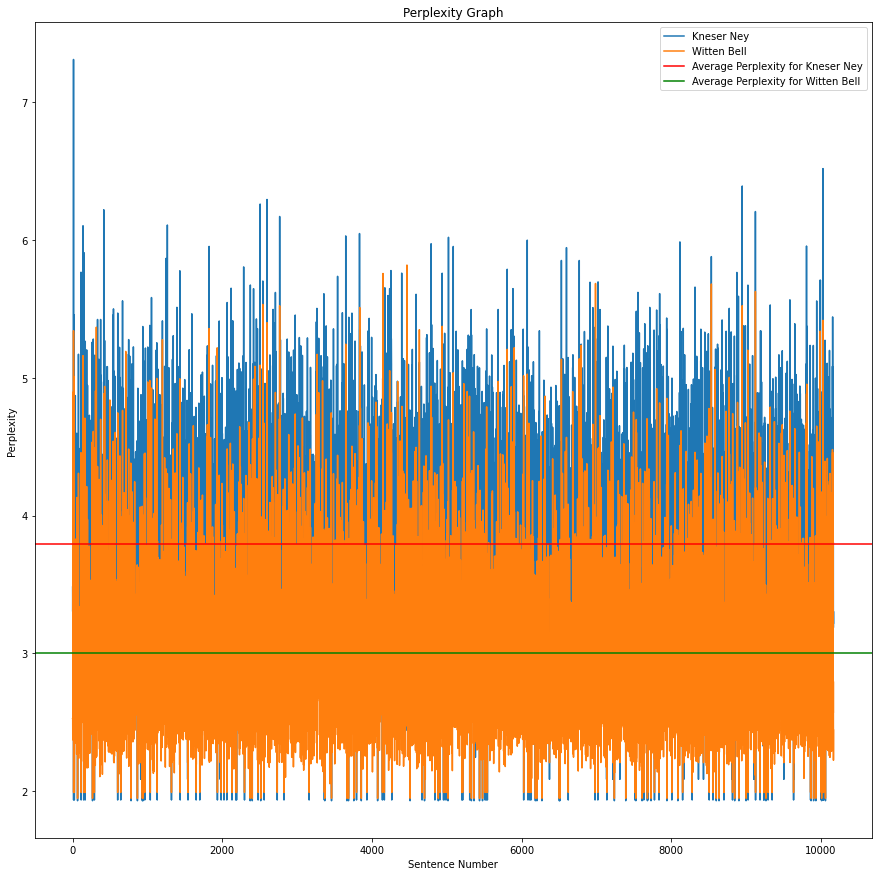

In [72]:
plotPerplexityGraph('../DATA/2020101050_LM1train-perplexity.txt','../DATA/2020101050_LM2train-perplexity.txt')

Average Perplexity for Kneser Ney:  333.5803939196564
Average Perplexity for Witten Bell:  363.26914413343894


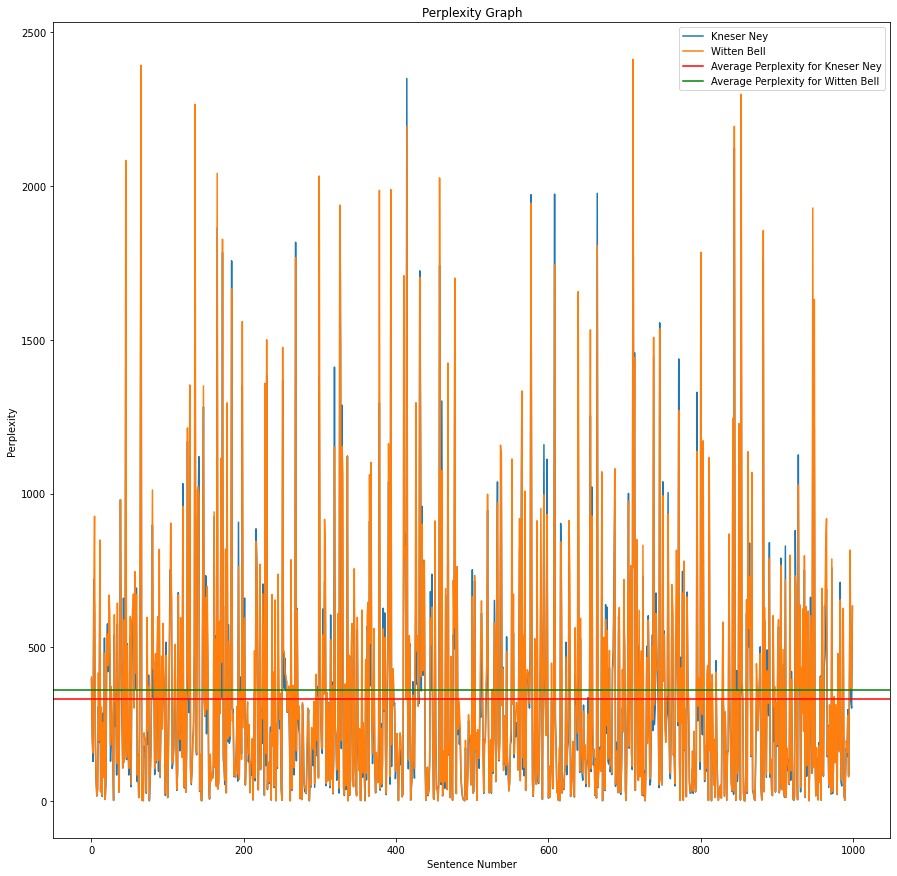

In [73]:
plotPerplexityGraph('../DATA/2020101050_LM1test-perplexity.txt',
                    '../DATA/2020101050_LM2test-perplexity.txt')


Average Perplexity for Kneser Ney:  4.132242178957028
Average Perplexity for Witten Bell:  3.382472858056434


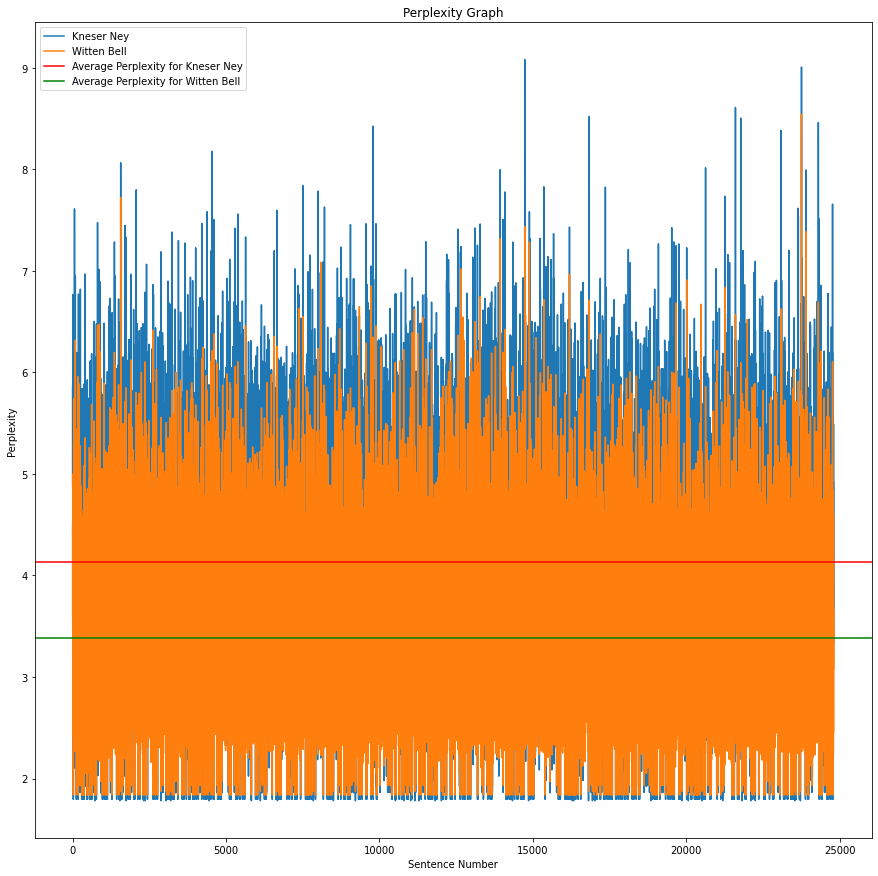

In [74]:
plotPerplexityGraph('../DATA/2020101050_LM3train-perplexity.txt',
                    '../DATA/2020101050_LM4train-perplexity.txt')


Average Perplexity for Kneser Ney:  639.1833368899953
Average Perplexity for Witten Bell:  705.1494741178086


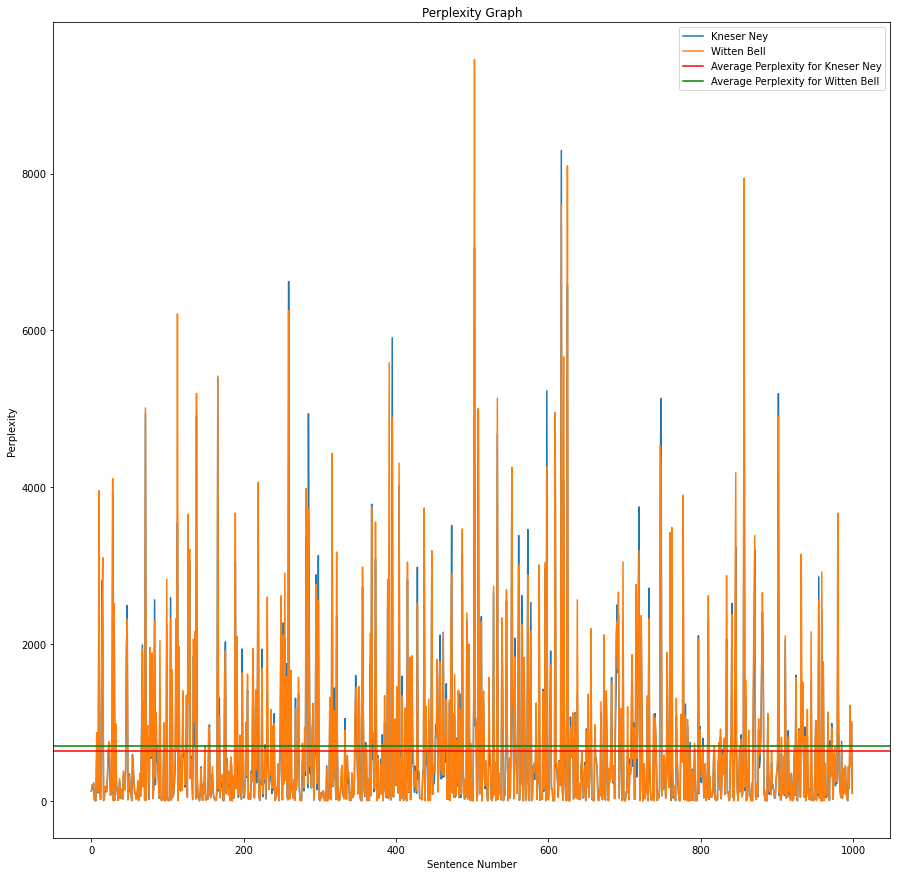

In [75]:
plotPerplexityGraph('../DATA/2020101050_LM3test-perplexity.txt',
                    '../DATA/2020101050_LM4test-perplexity.txt')
